In [1]:
# imports

from wrangle import the_office

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve
import statsmodels.api as sm

In [2]:
# getting the office data
df = the_office()
df.head() # check_yo_head

,episode,season,episode_title,about,ratings,votes,viewership,duration,date,director,writers,color
0,0,1,Pilot,The premiere episode introduces the boss and s...,7.5,4936,11.2,23,24 March 2005,Ken Kwapis,Ricky Gervais |Stephen Merchant and Greg Daniels,yellow
1,1,1,Diversity Day,Michael's off color remark puts a sensitivity ...,8.3,4801,6.0,23,29 March 2005,Ken Kwapis,B. J. Novak,lightgreen
2,2,1,Health Care,Michael leaves Dwight in charge of picking the...,7.8,4024,5.8,22,5 April 2005,Ken Whittingham,Paul Lieberstein,yellow
3,3,1,The Alliance,"Just for a laugh, Jim agrees to an alliance wi...",8.1,3915,5.4,23,12 April 2005,Bryan Gordon,Michael Schur,yellow
4,4,1,Basketball,Michael and his staff challenge the warehouse ...,8.4,4294,5.0,23,19 April 2005,Greg Daniels,Greg Daniels,lightgreen


In [3]:
df.date = pd.to_datetime(df.date)
df.dtypes

episode                   int64
season                    int64
episode_title            object
about                    object
ratings                 float64
votes                     int64
viewership              float64
duration                  int64
date             datetime64[ns]
director                 object
writers                  object
color                    object
dtype: object

In [4]:
df.date.head()

0   2005-03-24
1   2005-03-29
2   2005-04-05
3   2005-04-12
4   2005-04-19
Name: date, dtype: datetime64[ns]

In [5]:
df.head()

,episode,season,episode_title,about,ratings,votes,viewership,duration,date,director,writers,color
0,0,1,Pilot,The premiere episode introduces the boss and s...,7.5,4936,11.2,23,2005-03-24,Ken Kwapis,Ricky Gervais |Stephen Merchant and Greg Daniels,yellow
1,1,1,Diversity Day,Michael's off color remark puts a sensitivity ...,8.3,4801,6.0,23,2005-03-29,Ken Kwapis,B. J. Novak,lightgreen
2,2,1,Health Care,Michael leaves Dwight in charge of picking the...,7.8,4024,5.8,22,2005-04-05,Ken Whittingham,Paul Lieberstein,yellow
3,3,1,The Alliance,"Just for a laugh, Jim agrees to an alliance wi...",8.1,3915,5.4,23,2005-04-12,Bryan Gordon,Michael Schur,yellow
4,4,1,Basketball,Michael and his staff challenge the warehouse ...,8.4,4294,5.0,23,2005-04-19,Greg Daniels,Greg Daniels,lightgreen


In [6]:
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['day'] = df.date.dt.day
df['weekday'] = df.date.dt.day_name()
df.head()

,episode,season,episode_title,about,ratings,votes,viewership,duration,date,director,writers,color,year,month,day,weekday
0,0,1,Pilot,The premiere episode introduces the boss and s...,7.5,4936,11.2,23,2005-03-24,Ken Kwapis,Ricky Gervais |Stephen Merchant and Greg Daniels,yellow,2005,3,24,Thursday
1,1,1,Diversity Day,Michael's off color remark puts a sensitivity ...,8.3,4801,6.0,23,2005-03-29,Ken Kwapis,B. J. Novak,lightgreen,2005,3,29,Tuesday
2,2,1,Health Care,Michael leaves Dwight in charge of picking the...,7.8,4024,5.8,22,2005-04-05,Ken Whittingham,Paul Lieberstein,yellow,2005,4,5,Tuesday
3,3,1,The Alliance,"Just for a laugh, Jim agrees to an alliance wi...",8.1,3915,5.4,23,2005-04-12,Bryan Gordon,Michael Schur,yellow,2005,4,12,Tuesday
4,4,1,Basketball,Michael and his staff challenge the warehouse ...,8.4,4294,5.0,23,2005-04-19,Greg Daniels,Greg Daniels,lightgreen,2005,4,19,Tuesday


In [7]:
df = df.set_index('date').sort_index()
df.head()

,episode,season,episode_title,about,ratings,votes,viewership,duration,director,writers,color,year,month,day,weekday
date,,,,,,,,,,,,,,,
2005-03-24,0,1,Pilot,The premiere episode introduces the boss and s...,7.5,4936,11.2,23,Ken Kwapis,Ricky Gervais |Stephen Merchant and Greg Daniels,yellow,2005,3,24,Thursday
2005-03-29,1,1,Diversity Day,Michael's off color remark puts a sensitivity ...,8.3,4801,6.0,23,Ken Kwapis,B. J. Novak,lightgreen,2005,3,29,Tuesday
2005-04-05,2,1,Health Care,Michael leaves Dwight in charge of picking the...,7.8,4024,5.8,22,Ken Whittingham,Paul Lieberstein,yellow,2005,4,5,Tuesday
2005-04-12,3,1,The Alliance,"Just for a laugh, Jim agrees to an alliance wi...",8.1,3915,5.4,23,Bryan Gordon,Michael Schur,yellow,2005,4,12,Tuesday
2005-04-19,4,1,Basketball,Michael and his staff challenge the warehouse ...,8.4,4294,5.0,23,Greg Daniels,Greg Daniels,lightgreen,2005,4,19,Tuesday


In [8]:
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

In [9]:
print('Date Range:', df.index.min(), 'to', df.index.max())
print('Shape:', df.shape)

df.head(10)

Date Range: 2005-03-24 00:00:00 to 2013-05-16 00:00:00
Shape: (188, 15)


,episode,season,episode_title,about,ratings,votes,viewership,duration,director,writers,color,year,month,day,weekday
date,,,,,,,,,,,,,,,
2005-03-24,0,1,Pilot,The premiere episode introduces the boss and s...,7.5,4936,11.20,23,Ken Kwapis,Ricky Gervais |Stephen Merchant and Greg Daniels,yellow,2005,3,24,Thursday
2005-03-29,1,1,Diversity Day,Michael's off color remark puts a sensitivity ...,8.3,4801,6.00,23,Ken Kwapis,B. J. Novak,lightgreen,2005,3,29,Tuesday
2005-04-05,2,1,Health Care,Michael leaves Dwight in charge of picking the...,7.8,4024,5.80,22,Ken Whittingham,Paul Lieberstein,yellow,2005,4,5,Tuesday
2005-04-12,3,1,The Alliance,"Just for a laugh, Jim agrees to an alliance wi...",8.1,3915,5.40,23,Bryan Gordon,Michael Schur,yellow,2005,4,12,Tuesday
2005-04-19,4,1,Basketball,Michael and his staff challenge the warehouse ...,8.4,4294,5.00,23,Greg Daniels,Greg Daniels,lightgreen,2005,4,19,Tuesday
2005-04-26,5,1,Hot Girl,Michael is just one of the many male staff who...,7.7,3854,4.80,23,Amy Heckerling,Mindy Kaling,yellow,2005,4,26,Tuesday
2005-09-20,6,2,The Dundies,"Very much unlike his staff, an overeager Micha...",8.7,4315,9.00,21,Greg Daniels,Mindy Kaling,lightgreen,2005,9,20,Tuesday
2005-09-27,7,2,Sexual Harassment,The office reviews its sexual harassment polic...,8.2,3665,7.13,22,Ken Kwapis,B. J. Novak,lightgreen,2005,9,27,Tuesday
2005-10-04,8,2,Office Olympics,"Ready to finalize his deal for a new condo, Mi...",8.4,3665,8.30,22,Paul Feig,Michael Schur,lightgreen,2005,10,4,Tuesday


In [ ]:
# percentage based
train_size = .70
n = df.shape[0]
test_start_index = round(train_size * n)

train = df[:test_start_index] # everything up (not including) to the test_start_index
test = df[test_start_index:] # everything from the test_start_index to the end

plt.plot(train.index, train.viewership)
plt.plot(test.index, test.viewership)

In [ ]:
train = df[:'2010'] # includes everything into 2010
test = df['2011':] # everthing from 2011 to the last episode

plt.plot(train.index, train.viewership)
plt.plot(test.index, test.viewership)

In [ ]:
y = train.viewership
y.head()

In [ ]:
y.plot.hist()

In [ ]:
ax = y.groupby(y.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Views by Month', xlabel='Month', ylabel='Views')

In [ ]:
ax = y.groupby(y.index.day).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Views by Day', xlabel='Day', ylabel='Views')

In [ ]:
y.groupby(y.index.day_name()).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Temperature by Weekday', xlabel='Weekday', ylabel='Temp (F)')

In [ ]:
(
    y.reset_index()
    .assign(weekday=lambda df: df.date.dt.day_name())
    .pipe((sns.boxplot, 'data'), y='viewership', x='weekday')
)

In [ ]:
y.plot()

In [ ]:
y.resample('2W').mean().plot(title='2 week average')


In [ ]:
y.plot(alpha=.2, label='Hourly')
y.resample('D').mean().plot(alpha=.5, label='Daily')
y.resample('W').mean().plot(alpha=.8, label='Weekly')
y.resample('M').mean().plot(label='Montly')
y.resample('Y').mean().plot(label='Yearly')
plt.legend()


In [ ]:
y.plot(alpha=.2, label='Hourly')
y.resample('D').mean().rolling(3).mean().plot(alpha=.5, label='3 day')
y.resample('D').mean().rolling(7).mean().plot(alpha=.8, label='1 week')
plt.legend()

In [ ]:
y.resample('W').mean().diff().plot(title='Average week-to-week change in viewership')


In [ ]:
y.resample('M').mean().diff().plot(title='Average month-to-month change in Viewership')


In [ ]:
# .unstack turns an index level into columns
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(title='Seasonal Plot')


In [ ]:
table = y.groupby([y.index.year, y.index.month]).mean().unstack()

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month)
    ax.hlines(subset.mean(), *ax.get_xlim())
    ax.set(xlabel='')

fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=0)


In [ ]:
plt.scatter(y, y.shift(-1))
plt.xlabel('$y$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag=1')


In [ ]:
train['y(t + 1)'] = train.viewership.shift(-1)
ax = train.plot.scatter(x='viewership', y='y(t + 1)')
ax.set(xlabel='t', ylabel='t + 1')


In [ ]:
pd.plotting.autocorrelation_plot(train.viewership.resample('Y').mean())


In [ ]:
train = train.resample('D').mean()
# create a categorical feature
train['view_bin'] = pd.qcut(train.viewership, 4, labels=['cold', 'cool', 'warm', 'hot'])
train.groupby('view_bin').mean()


In [ ]:
(train.groupby('view_bin')
 .resample('M')
 .size()
 .unstack(0)
 .apply(lambda row: row / row.sum(), axis=1)
 .plot.area()
)
plt.ylabel('% of days in the month')


In [ ]:
train.head()

In [ ]:
ax = (train
 .groupby('view_bin')
 .resample('M')
 .size()
 .unstack(0)
 .plot.bar(stacked=True, width=.9, ec='black')
)
labels = [pd.to_datetime(t.get_text()).strftime('%B') for t in ax.get_xticklabels()]
ax.set_xticklabels(labels)


In [ ]:
ax = y.groupby(y.index.strftime('%m-%b')).mean().plot.bar()
ax.set_xticklabels([t.get_text()[3:] for t in ax.get_xticklabels()], rotation=0)
None


In [ ]:
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots()

weekly = y.resample('W').mean()

ax.plot(weekly.index, weekly)

ax.xaxis.set_major_formatter(DateFormatter('%b %y'))


# Modeling

In [10]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

In [11]:
df = df.drop(columns= {'episode_title', 'episode', 'season', 'about', 'director', 'writers', 'color', 'year', 'month', 'day', 'weekday', 'votes', 'duration'})

In [12]:
df.head()

,ratings,viewership
date,,
2005-03-24,7.5,11.2
2005-03-29,8.3,6.0
2005-04-05,7.8,5.8
2005-04-12,8.1,5.4
2005-04-19,8.4,5.0


In [13]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

In [14]:
print(len(train) + len(validate) + len(test) == len(df))

True


In [15]:
print(df.head(1) == train.head(1))

            ratings  viewership
date                           
2005-03-24     True        True


In [16]:
pd.concat([train.tail(1), validate.head(1)])
pd.concat([validate.tail(1), test.head(1)])


,ratings,viewership
date,,
2011-12-01,7.7,5.71
2011-12-08,7.9,5.79


In [17]:
pd.concat([test.tail(1), df.tail(1)])

,ratings,viewership
date,,
2013-05-16,9.8,5.69
2013-05-16,9.8,5.69


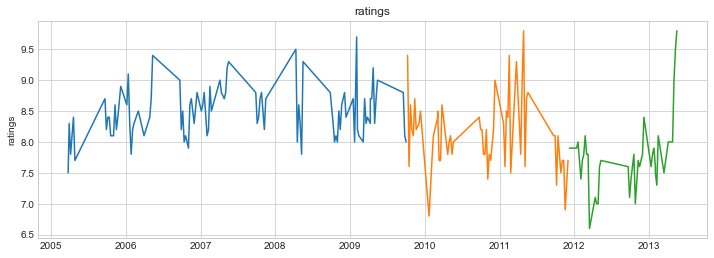

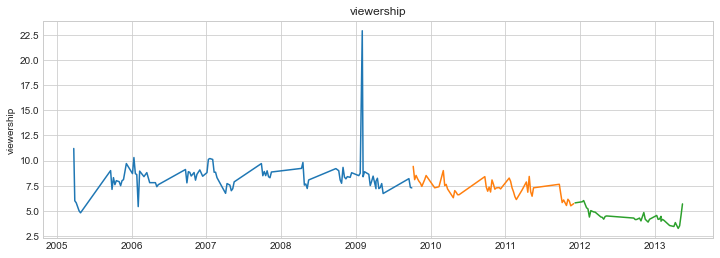

In [18]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()


In [19]:
# evaluation function to compute rmse

def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse


In [20]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()


In [21]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)


In [22]:
eval_df

,model_type,target_var,rmse


In [23]:
# Forcast
# Last observed value
views = train['viewership'][-1:][0]
ratings = round(train['ratings'][-1:][0],2)

yhat_df = pd.DataFrame({'viewership': [views], 'ratings': [ratings]}, 
                       index = validate.index)

yhat_df.head(2)


,viewership,ratings
date,,
2009-10-08,7.28,8.0
2009-10-08,7.28,8.0


ratings -- RMSE: 1


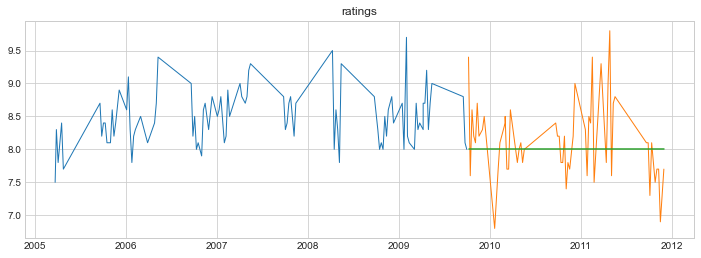

viewership -- RMSE: 1


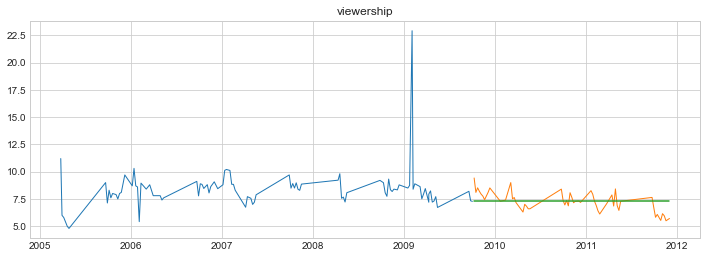

In [24]:
for col in train.columns:
    plot_and_eval(col)

In [25]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)


In [26]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,ratings,1.0
1,last_observed_value,viewership,1.0


In [28]:
# simple average

views = round(train['viewership'].mean(), 2)
ratings = round(train['ratings'].mean(), 2)

def make_predictions():
    yhat_df = pd.DataFrame({'viewership': [views],
                            'ratings': [ratings],
                           }, index = validate.index)
    return yhat_df

yhat_df = make_predictions()


In [29]:
yhat_df.head(2)

,viewership,ratings
date,,
2009-10-08,8.33,8.47
2009-10-08,8.33,8.47


ratings -- RMSE: 1


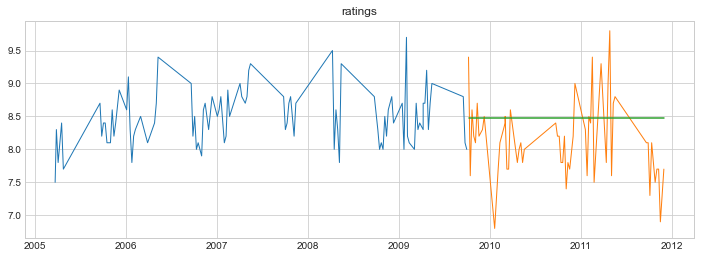

viewership -- RMSE: 1


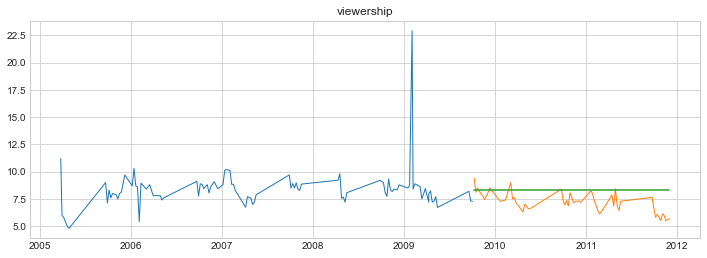

In [30]:
for col in train.columns:
    plot_and_eval(col)

In [31]:
# evaluate
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)

In [32]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,ratings,1.0
1,last_observed_value,viewership,1.0
2,simple_average,ratings,1.0
3,simple_average,viewership,1.0


In [33]:
# moving average
# compute a 30 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 30

views = round(train['viewership'].rolling(period).mean().iloc[-1], 2)
ratings = round(train['ratings'].rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions()
yhat_df.head(3)

,viewership,ratings
date,,
2009-10-08,8.62,8.5
2009-10-08,8.62,8.5
2009-10-15,8.62,8.5


ratings -- RMSE: 1


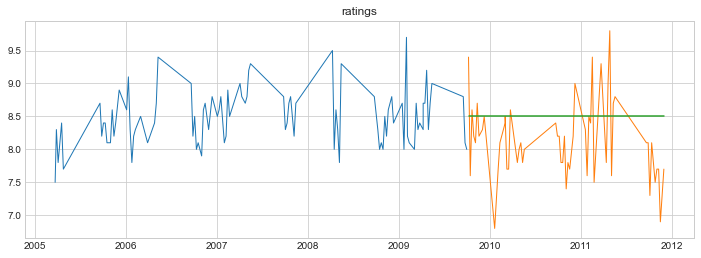

viewership -- RMSE: 2


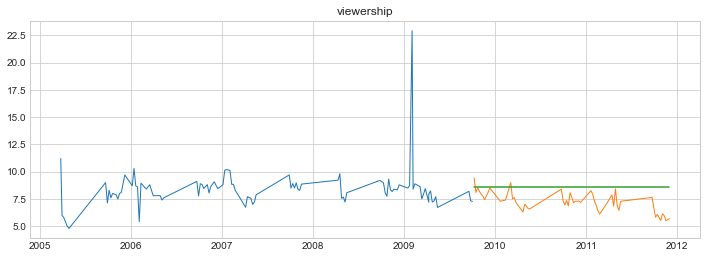

In [34]:
for col in train.columns:
    plot_and_eval(col)

In [35]:
for col in train.columns:
    eval_df = append_eval_df(model_type='30d moving average', 
                             target_var = col)

In [36]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,ratings,1.0
1,last_observed_value,viewership,1.0
2,simple_average,ratings,1.0
3,simple_average,viewership,1.0
4,30d moving average,ratings,1.0
5,30d moving average,viewership,2.0


In [40]:
periods = [1, 7, 14, 30]

for p in periods:
    views = round(train['viewership'].rolling(p).mean().iloc[-1], 2)
    ratings = round(train['ratings'].rolling(p).mean().iloc[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'd moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'viewership'
                            )
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'ratings'
                            )


In [41]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,ratings,1.0
1,last_observed_value,viewership,1.0
2,simple_average,ratings,1.0
3,simple_average,viewership,1.0
4,30d moving average,ratings,1.0
5,30d moving average,viewership,2.0
6,1d moving average,viewership,1.0
7,1d moving average,ratings,1.0
8,4d moving average,viewership,1.0
9,4d moving average,ratings,1.0


In [42]:
# get the min rmse for each variable

min_rmse_ratings = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_views = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_ratings) | 
         (eval_df.rmse == min_rmse_views)
        )]


,model_type,target_var,rmse
0,last_observed_value,ratings,1.0
1,last_observed_value,viewership,1.0
2,simple_average,ratings,1.0
3,simple_average,viewership,1.0
4,30d moving average,ratings,1.0
6,1d moving average,viewership,1.0
7,1d moving average,ratings,1.0
8,4d moving average,viewership,1.0
9,4d moving average,ratings,1.0
10,12d moving average,viewership,1.0


In [44]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)


KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

ratings -- RMSE: 1


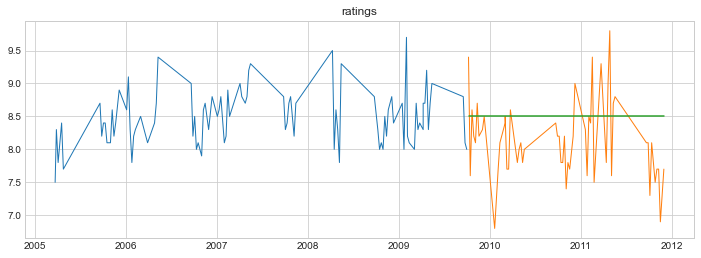

viewership -- RMSE: 2


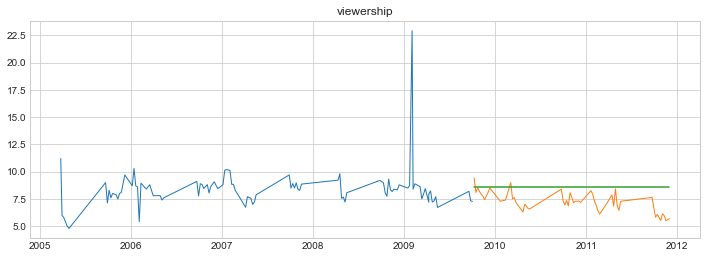

In [45]:
for col in train.columns:
    plot_and_eval(target_var = col)


In [46]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)


In [47]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,ratings,1.0
1,last_observed_value,viewership,1.0
2,simple_average,ratings,1.0
3,simple_average,viewership,1.0
4,30d moving average,ratings,1.0
5,30d moving average,viewership,2.0
6,1d moving average,viewership,1.0
7,1d moving average,ratings,1.0
8,4d moving average,viewership,1.0
9,4d moving average,ratings,1.0
